In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
np.random.seed(42)
idx = pd.IndexSlice

Sample [implementation](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/08_ml4t_workflow/04_ml4t_workflow_with_zipline/02_backtesting_with_zipline.ipynb) of a long-short strategy based on ML predictions using a custom `DataFrameLoader`.

### Load zipline extensions

Only need this in notebook to find bundle.

In [5]:
from zipline.utils.run_algo import load_extensions

load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [7]:
from logbook import Logger, StderrHandler, INFO


log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

### Algo Params

We plan to hold up to 10 long and 10 short positions whenever there are at least 5 on either side that meet the criteria (positive/negative prediction for long/short position).

In [8]:
N_LONGS = 10
N_SHORTS = 10
MIN_POSITIONS = 5

## Load Data

### Quandl Wiki Bundle

Load the Wiki Quandl bundle data that we ingested earlier using zipline ingest. This gives us access to the security SID values, among other things.

In [14]:
from zipline.data import bundles

bundle_data = bundles.load('quandl')

### ML Predictions

We load our predictions extract the Zipline IDs using the `bundle.asset_finder.lookup_symbols()`.

In [15]:
def load_predictions(bundle):
    predictions = pd.read_hdf('predictions.h5', key='lasso_regression')
    
    predictions = predictions[~predictions.index.duplicated()]
    tickers = predictions.index.get_level_values('ticker').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('ticker')
            .rename(columns=ticker_map)
            .tz_localize('UTC')), assets

In [17]:
predictions, assets = load_predictions(bundle_data)

predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2012-12-31 to 2016-12-29
Columns: 500 entries, 0 to 3193
dtypes: float64(500)
memory usage: 3.9 MB


In [18]:
len(assets)
assets[:5]

500

[Equity(0 [A]),
 Equity(2 [AAL]),
 Equity(7 [AAP]),
 Equity(8 [AAPL]),
 Equity(13 [ABC])]

### Define Custom Dataset

To merge additional columns with our bundle, we define a custom `SignalData` class that inherits from `zipline.pipeline.DataSet` and contains a single `zipline.pipeline.Column` of type `float` and has the domain `US_EQUITIES`:

In [20]:
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES

class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

### Define Pipeline Loaders

While the bundle’s OHLCV data can rely on the built-in `USEquityPricingLoader`, we need to define our own `zipline.pipeline.loaders.frame.DataFrameLoader`:

In [22]:
from zipline.pipeline.loaders.frame import DataFrameLoader

signal_loader = {SignalData.predictions:
                 DataFrameLoader(SignalData.predictions, predictions)}

## Pipeline Setup

Our Pipeline is going to have two Boolean columns that identify the assets we would like to trade as long and short positions.

To get there, we first define a `CustomFacto`r called `MLSignal` that just receives the current `SignalData.predictions`. The motivation is to allow us to use some of the convenient Factor methods designed to rank and filter securities.

### Custom ML Factor

In [24]:
from zipline.pipeline import CustomFactor

class MLSignal(CustomFactor):
    """Converting signals to Factor
       so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, preds):
        out[:] = preds

### Create Pipeline

Now we create a `compute_signals()` that returns a `zipline.pipeline.Pipeline` which filters the assets that meet our long/short criteria. We will call ths function periodically while executing the backtest.

More specifically, we set up our Pipeline by instantiating the `CustomFactor` that requires no arguments other than the defaults. We combine its `top()` and `bottom()` methods with a filter to select the highest positive and lowest negative predictions:

In [41]:
from zipline.pipeline import Pipeline
from zipline.pipeline.filters import StaticAssets

def compute_signals():
    signals = MLSignal()
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
                    screen=StaticAssets(assets))

## Initialize Algorithm

The `initialize()` function is part of the Algorithm API. It permits us to add entries to the context dictionary available to all backtest components, set parameters like commission and slippage, and schedule functions. We also attach our Pipeline to the algorithm:

In [43]:
from zipline import run_algorithm
from zipline.api import (attach_pipeline,
                         pipeline_output,
                         date_rules,
                         time_rules,
                         record,
                         schedule_function,
                         commission,
                         slippage,
                         set_slippage,
                         set_commission,
                         set_max_leverage,
                         order_target,
                         order_target_percent,
                         get_open_orders,
                         cancel_order)

In [26]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets
    context.trades = pd.Series()
    context.longs = context.shorts = 0
    
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0.001, min_trade_cost=0))

    schedule_function(rebalance,
                      date_rules.every_day(),
#                       date_rules.week_start(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### Get daily Pipeline results

The algorithm calls the `before_trading_start()` function every day before market opens and we use it to obtain the current pipeline values, i.e., the assets suggested for long and short positions based on the ML model predictions:

In [28]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    df = (output['longs'].astype(int)
          .append(output['shorts'].astype(int).mul(-1)))
    
    holdings = df[df!=0]
    other = df[df==0]
    other = other[~other.index.isin(holdings.index) & ~other.index.duplicated()]
    context.trades = holdings.append(other)
    assert len(context.trades.index.unique()) == len(context.trades)

## Define Rebalancing Logic

The `rebalance()` function takes care of adjusting the portfolio positions to reflect the target long and short positions implied by the model forecasets:

In [30]:
from collections import defaultdict

def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    positions = context.portfolio.positions
    s=pd.Series({s:v.amount*v.last_sale_price for s, v in positions.items()}).sort_values(ascending=False)
    for stock, trade in context.trades.items():
        if trade == 0:
            order_target(stock, target=0)
        else:
            trades[trade].append(stock)
    
    context.longs, context.shorts = len(trades[1]), len(trades[-1])
#     log.warning('{} {:,.0f}'.format(len(positions), context.portfolio.portfolio_value))
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)
    else:
        for stock in trades[-1] + trades[1]:
            if stock in positions:
                order_target(stock, 0)

## Record Data Points

The `record_vars()` logs information to the `pd.DataFrame` returned by `run_algorithm()` as scheduled.

In [31]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

## Run Algorithm

At this point, we have defined all ingredients for the algorithm and are ready to call `run_algorithm()` with the desired start and end dates, references to the various functions we just created, and the `custom_loader` to ensure our model predictions are available to the backtest.

In [32]:
dates = predictions.index.get_level_values('date')
start_date, end_date = dates.min(), dates.max()

start_date, end_date

(Timestamp('2012-12-31 00:00:00+0000', tz='UTC'),
 Timestamp('2016-12-29 00:00:00+0000', tz='UTC'))

In [44]:
%%time
results = run_algorithm(start=pd.Timestamp('2014-01-12', tz='UTC'),
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e5,
                        data_frequency='daily',
                        bundle='quandl',
                        custom_loader=signal_loader)  # need to modify zipline

[2021-01-10 22:39:13.907352]: WARNING: _load_cached_data: Refusing to download new benchmark data because a download succeeded at 2021-01-10 22:36:47.859008+00:00.
[2021-01-10 22:39:13.957715]: WARNING: _load_cached_data: Refusing to download new treasury data because a download succeeded at 2021-01-10 22:36:51.544589+00:00.
[2021-01-10 22:39:56.598264]: INFO: handle_split: after split: asset: Equity(598 [CLR]), amount: 104, cost_basis: 74.63, last_sale_price: 149.25
[2021-01-10 22:39:56.600089]: INFO: handle_split: returning cash: 0.0
[2021-01-10 22:41:05.610204]: INFO: handle_split: after split: asset: Equity(440 [BTU]), amount: 419, cost_basis: 20.71, last_sale_price: 1.3800000000000001
[2021-01-10 22:41:05.611525]: INFO: handle_split: returning cash: 4.14
[2021-01-10 22:41:36.122561]: INFO: handle_split: after split: asset: Equity(2905 [UAA]), amount: 234, cost_basis: 41.81, last_sale_price: 85.97
[2021-01-10 22:41:36.126458]: INFO: handle_split: returning cash: 0.0
[2021-01-10 22:

CPU times: user 1min 20s, sys: 15.5 s, total: 1min 35s
Wall time: 3min 18s


## PyFolio Analysis

Now we can evaluate the results using [`pyfolio`](https://quantopian.github.io/pyfolio/) tearsheets or its various `pyfolio.plotting` functions.

In [48]:
import pandas_datareader as pdr

benchmark = pdr.get_data_fred('SP500', start='2013', end='2017').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

benchmark.head()

DATE
2013-01-01 00:00:00+00:00         NaN
2013-01-02 00:00:00+00:00         NaN
2013-01-03 00:00:00+00:00   -0.002086
2013-01-04 00:00:00+00:00    0.004865
2013-01-07 00:00:00+00:00   -0.003123
Name: SP500, dtype: float64

In [49]:
import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [50]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results['2011':'2016'])

### Custom Plots

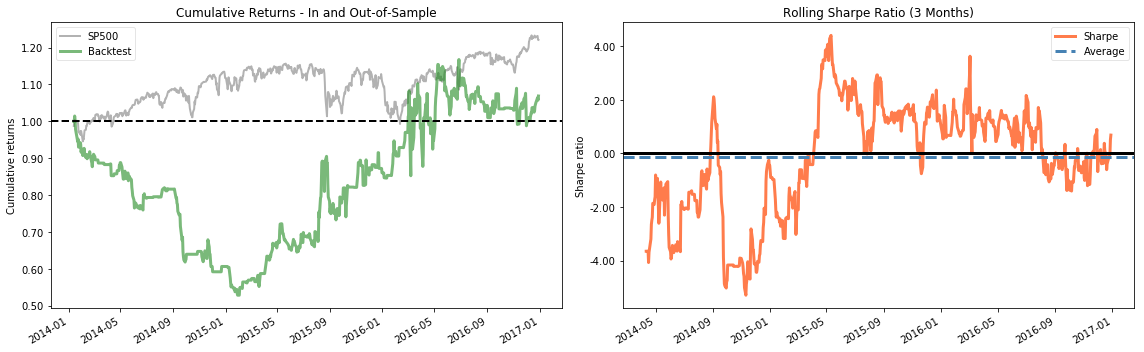

In [53]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
_ = plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                     ax=axes[0])
_ = plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63);
_ = axes[0].set_title('Cumulative Returns - In and Out-of-Sample');
_ = axes[1].set_title('Rolling Sharpe Ratio (3 Months)');
fig.tight_layout()

### Tear Sheets

Start date,2014-01-13
End date,2016-12-29
Total months,35
,Backtest
Annual return,2.3%
Cumulative returns,6.9%
Annual volatility,35.6%
Sharpe ratio,0.24
Calmar ratio,0.05
Stability,0.30
Max drawdown,-47.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,47.92,2014-01-15,2015-02-02,2016-03-03,557
1,21.25,2016-03-03,2016-03-07,2016-03-23,15
2,20.34,2016-03-23,2016-04-04,2016-05-09,34
3,15.39,2016-06-27,2016-12-01,NaT,NaN
4,11.91,2016-05-09,2016-06-06,2016-06-27,36


Stress Events,mean,min,max
Apr14,0.03%,-3.60%,1.71%
Oct14,0.15%,-0.02%,2.32%
Fall2015,-0.32%,-9.02%,8.59%
New Normal,0.03%,-14.37%,21.68%


Top 10 long positions of all time,max
sid,
UPL,19.73%
TGT,17.66%
JWN,17.61%
FE,17.53%
CPB,17.42%
EA,17.37%
NOV,17.07%
WFM,17.07%
ACI,17.05%


Top 10 short positions of all time,max
sid,
ACI,-21.09%
DNR,-19.90%
WLL,-18.44%
CHK,-17.77%
MRO,-17.69%
FCX,-17.63%
UPL,-17.62%
WMB,-17.57%
NBR,-17.47%


Top 10 positions of all time,max
sid,
ACI,21.09%
DNR,19.90%
UPL,19.73%
WLL,18.44%
CHK,17.77%
MRO,17.69%
TGT,17.66%
FCX,17.63%
JWN,17.61%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,6474.00,3398.00,3076.00
Percent profitable,0.47,0.47,0.48
Winning round_trips,3070.00,1588.00,1482.00
Losing round_trips,3340.00,1777.00,1563.00
Even round_trips,64.00,33.00,31.00


PnL stats,All trades,Short trades,Long trades
Total profit,$20633.65,$11132.95,$9500.69
Gross profit,$695727.60,$313053.93,$382673.67
Gross loss,$-675093.95,$-301920.97,$-373172.98
Profit factor,$1.03,$1.04,$1.03
Avg. trade net profit,$3.19,$3.28,$3.09
Avg. winning trade,$226.62,$197.14,$258.21
Avg. losing trade,$-202.12,$-169.90,$-238.75
Ratio Avg. Win:Avg. Loss,$1.12,$1.16,$1.08
Largest winning trade,$16888.20,$4689.96,$16888.20
Largest losing trade,$-23191.60,$-7076.56,$-23191.60


Duration stats,All trades,Short trades,Long trades
Avg duration,3 days 16:15:38.090824,3 days 03:26:35.526780,4 days 06:25:10.923276
Median duration,2 days 00:00:00,2 days 00:00:00,2 days 00:00:00
Longest duration,173 days 00:00:00,173 days 00:00:00,119 days 01:00:00
Shortest duration,0 days 03:00:01,0 days 03:00:01,0 days 20:59:59


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.02%,0.01%,0.03%
Avg returns winning,0.25%,0.21%,0.28%
Avg returns losing,-0.19%,-0.16%,-0.23%
Median returns all round_trips,-0.00%,-0.00%,0.00%
Median returns winning,0.07%,0.08%,0.06%
Median returns losing,-0.06%,-0.06%,-0.06%
Largest winning trade,16.68%,4.91%,16.68%
Largest losing trade,-25.43%,-8.53%,-25.43%


Symbol stats,A,AAL,AAP,AAPL,ABC,ABT,ACE,ACI,ADBE,ADI,ADM,ADS,ADSK,AEO,AEP,AES,AET,AGN,AIG,AKAM,AKS,ALL,ALTR,ALXN,AMAT,AMD,AMG,AMGN,AMP,AMT,AMTD,AMZN,ANF,ANR,ANTM,APA,APC,APD,APOL,ARNC,ASH,ATI,ATVI,AVB,AVP,AXP,AZO,BA,BAC,BBBY,BBT,BBY,BCR,BDX,BEAM,BG,BHI,BIDU,BIIB,BK,BLL,BMRN,BMY,BRCD,BRCM,BRK_B,BSX,BTU,BWA,C,CA,CAG,CAH,CAM,CB,CBG,CCE,CCI,CCL,CE,CELG,CERN,CF,CHK,CHKP,CHRW,CI,CIEN,CL,CLF,CLR,CLX,CMA,CMCSA,CMCSK,CME,CMG,CMS,CNP,CNX,COF,COG,COH,COP,CPB,CPN,CREE,CRM,CSX,CTL,CTSH,CTXS,CVS,CVX,CXO,CYH,D,DAL,DD,DE,DECK,DF,DFS,DGX,DHI,DHR,DIS,DISCA,DISH,DKS,DLTR,DNR,DO,DOV,DOW,DPS,DRI,DTE,DTV,DUK,DVA,DVN,EA,EBAY,ECL,ED,EIX,EL,ENDP,EOG,EQIX,EQR,EQT,ESRX,ESV,ETFC,ETN,ETR,EW,EXC,EXPD,EXPE,F,FAST,FCX,FDO,FDX,FE,FFIV,FIS,FISV,FITB,FL,FLR,FLS,FRX,FSLR,FTI,GE,GGP,GILD,GIS,GLW,GMCR,GME,GNW,GOOGL,GPS,GRMN,GS,GT,HAL,HAS,HBAN,HCN,HCP,HES,HFC,HIG,HOG,HOLX,HOT,HP,HPQ,HRB,HSH,HSP,HST,HSY,HTZ,HUM,IACI,IBM,ICE,IGT,ILMN,INTC,INTU,ISRG,IVZ,JBHT,JBLU,JCI,JCP,JDSU,JNJ,JNPR,JOY,JPM,JWN,K,KBH,KEY,KIM,KLAC,KMB,KMX,KO,KR,KSS,KSU,L,LB,LBTYA,LEN,LH,LLL,LLTC,LLY,LM,LMT,LNC,LOW,LRCX,LUV,LVLT,LVS,M,MA,MAR,MAS,MAT,MCD,MCK,MDLZ,MDT,MET,MGM,MLM,MMC,MNST,MO,MON,MOS,MRK,MRO,MRVL,MS,MSFT,MSI,MTB,MU,MUR,MXIM,MYL,NBL,NBR,NDAQ,NE,NEE,NEM,NFLX,NFX,NKE,NLY,NOV,NRG,NSC,NTAP,NTRS,NUAN,NUE,NVDA,NWL,OCR,ONNN,ORCL,ORLY,PAYX,PCG,PCLN,PCP,PEG,PETM,PFG,PG,PGR,PHM,PLD,PM,PNC,PNRA,PPL,PRGO,PRU,PSA,PTEN,PVH,PWR,PXD,QCOM,RAI,RCL,RDC,RF,RHT,RIG,RL,ROK,ROST,RRC,RSG,RTN,RVBD,S,SBAC,SBUX,SCCO,SCHW,SE,SHW,SIAL,SLB,SLM,SM,SNDK,SO,SPG,SPLS,STI,STJ,STLD,STT,STX,STZ,SUNE,SWK,SWKS,SWN,SWY,SYK,SYMC,SYY,T,TAP,TDC,TEL,TEX,TGT,THC,TIF,TMO,TMUS,TOL,TROW,TRV,TSN,TSO,TWC,TWX,TXN,TXT,TYC,UAA,UAL,UHS,UNH,UNM,UNP,UPL,UPS,URBN,URI,USB,UTHR,V,VIAB,VLO,VMW,VNO,VOD,VRSN,VRTX,VRX,VTR,VZ,WAG,WAT,WBA,WDC,WFC,WFM,WHR,WLL,WLT,WMB,WMT,WSM,WU,WY,WYNN,X,XEC,XL,XLNX,XRX,YHOO,YUM,ZBH,ZION,ZMH
Avg returns all round_trips,0.18%,0.04%,0.22%,-0.02%,-0.01%,0.13%,0.00%,0.00%,0.07%,-0.03%,0.12%,0.02%,0.12%,0.04%,-0.09%,0.04%,-0.01%,-0.04%,-0.32%,-0.02%,-0.07%,-0.00%,0.15%,-0.11%,-0.04%,0.05%,-0.19%,0.08%,0.04%,-0.04%,0.10%,-0.02%,-0.02%,-0.10%,-0.03%,-0.12%,0.02%,0.03%,0.00%,0.01%,-0.07%,0.04%,0.01%,-0.01%,-0.01%,0.02%,0.14%,-0.08%,-0.05%,-0.01%,0.03%,0.02%,-0.18%,-0.06%,-0.00%,0.05%,-0.25%,0.19%,0.03%,-0.02%,nan%,-0.02%,-0.02%,-0.10%,-0.07%,-0.00%,0.05%,0.14%,0.11%,0.01%,-0.02%,0.06%,-0.03%,-0.05%,-0.02%,-0.00%,-0.04%,0.08%,-0.08%,-0.11%,-0.03%,0.05%,0.12%,0.14%,0.08%,-0.02%,-0.05%,-0.02%,0.05%,0.06%,0.02%,-0.03%,-0.04%,-0.06%,-0.08%,0.22%,0.07%,0.05%,nan%,-0.05%,0.00%,0.16%,-0.09%,-0.06%,-0.05%,0.09%,0.02%,0.02%,0.05%,0.05%,-0.03%,-0.08%,-0.11%,-0.08%,0.02%,0.02%,nan%,0.02%,-0.09%,0.09%,0.11%,-0.02%,0.06%,-0.09%,-0.05%,-0.00%,-0.17%,-0.05%,-0.02%,0.04%,-0.00%,0.09%,0.04%,nan%,nan%,nan%,0.00%,0.09%,0.02%,nan%,nan%,0.02%,0.04%,0.04%,nan%,nan%,nan%,-0.39%,-0.01%,-0.03%,-0.07%,-0.03%,-0.01%,0.01%,0.03%,0.06%,0.02%,0.02%,-0.01%,0.00%,-0.04%,-0.00%,nan%,-0.02%,-0.13%,0.03%,0.01%,0.10%,-0.08%,0.06%,0.02%,0.00%,-0.15%,0.08%,0.12%,0.03%,0.03%,0.00%,-0.04%,-0.01%,0.01%,0.01%,0.03%,0.05%,-0.00%,0.11%,0.07%,-0.15%,-0.02%,-0.25%,-0.03%,0.18%,0.15%,-0.02%,-0.00%,0.03%,0.01%,0.01%,0.09%,0.24%,-0.05%,0.05%,0.32%,-0.23%,-0.06%,-0.38%,-0.01%,nan%,0.02%,0.15%,0.00%,-0.00%,nan%,0.10%,-0.03%,0.05%,0.02%,0.07%,0.07%,nan%,0.36%,-0.01%,nan%,0.01%,0.04%,-0.04%,0.06%,-0.00%,-0.04%,0.07%,0.04%,0.03%,-0.09%,0.03%,-0.02%,0.12%,0.04%,nan%,0.02%,-0.12%,0.18%,nan%,0.08%,0.01%,-0.25%,-0.02%,0.13%,-0.01%,0.04%,nan%,-0.01%,-0.11%,-0.13%,0.02%,-0.04%,-0.01%,-0.04%,0.16%,0.14%,-0.02%,0.00%,0.03%,-0.04%,-0.04%,0.06%,-0.06%,-0.14%,0.01%,-0.15%,0.01%,0.21%,0.08%,0.01%,-0.07%,0.08%,-0.07%,0.01%,-0.17%,-0.04%,-0.03%,-0.11%,0.12%,0.10%,0.00%,0.04%,0.08%,0.02%,0.01%,0.03%,-0.06%,0.04%,-0.01%,-0.02%,-0.20%,-0.05%,0.02%,0.20%,-0.10%,-0.03%,-0.05%,-0.04%,nan%,0.07%,0.02%,-0.07%,-0.06%,-0.21%,-0.05%,nan%,0.11%,0.01%,-0.00%,0.07%,-0.04%,-0.07%,-0.04%,0.11%,-0.09%,0.21%,0.04%,-0.12%,-0.05%,0.08%,0.08%,0.01%,0.04%,0.21%,-0.00%,0.06%,0.12%,-0.09%,-0.02%,0.10%,-0.05%,-0.04%,-0.

Profitability (PnL / PnL total) per name,
symbol,
UPL,129.30%
VRX,40.55%
BTU,36.89%
GNW,28.99%
HTZ,27.59%
CHK,23.31%
DNR,22.75%
NRG,16.65%
PTEN,16.62%


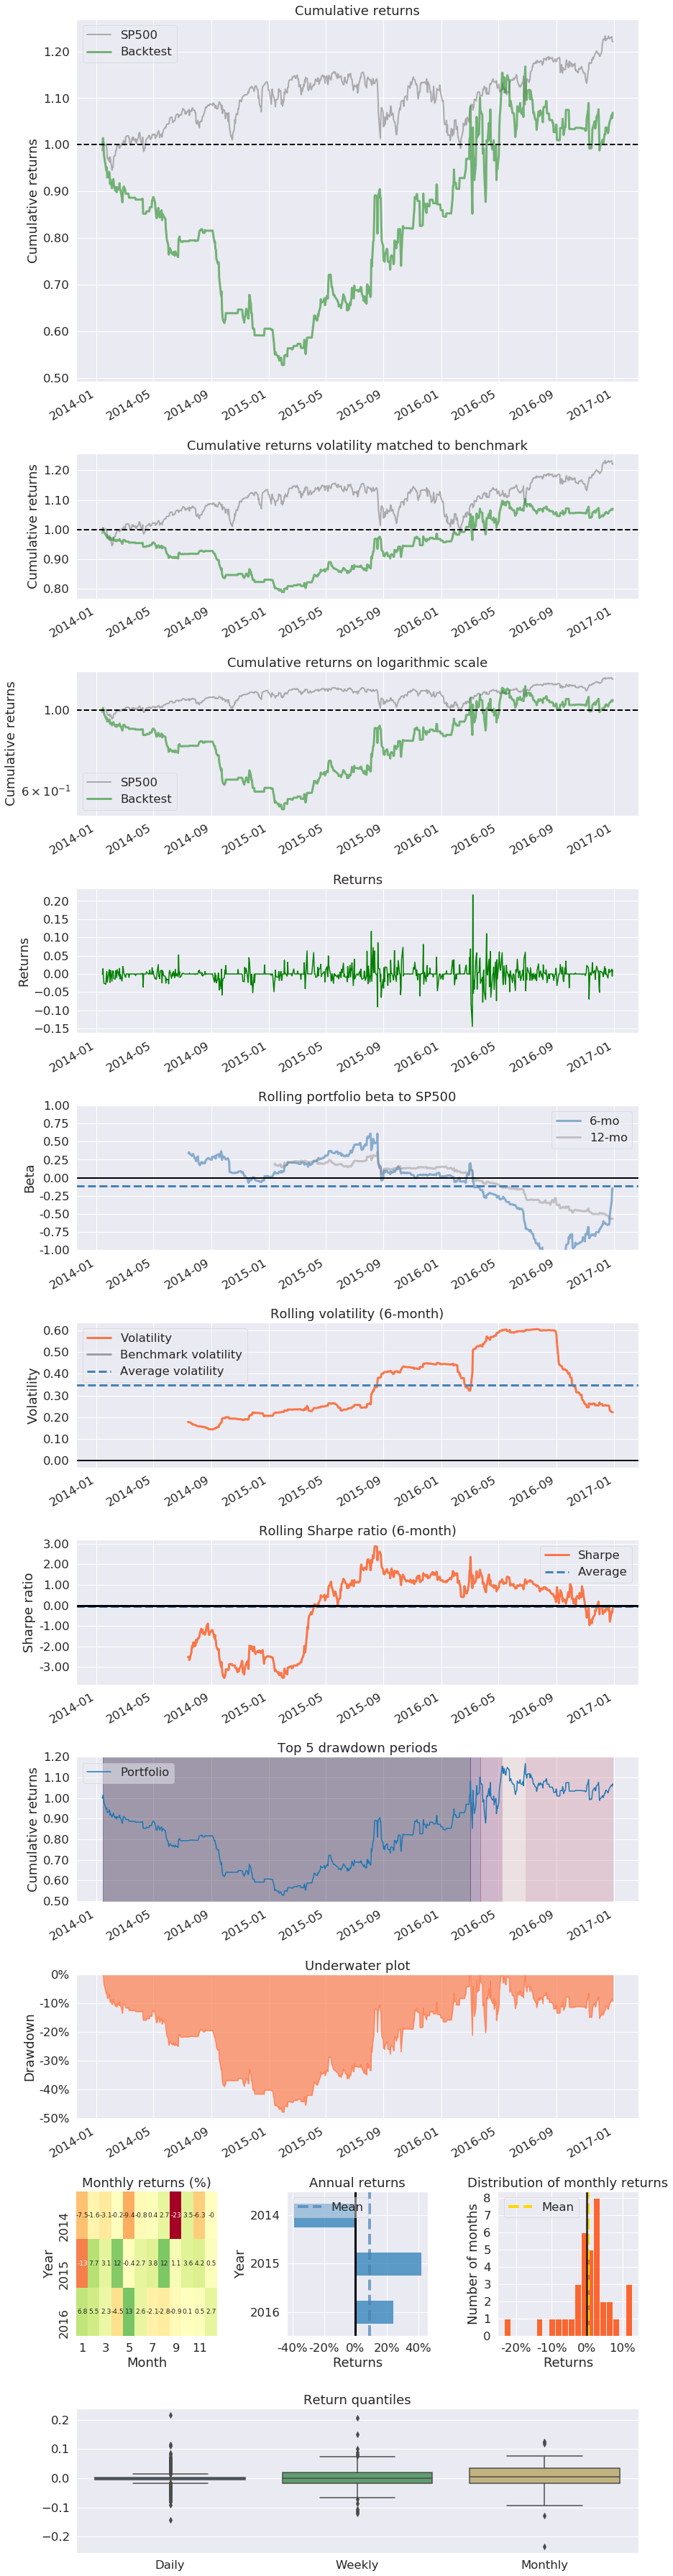

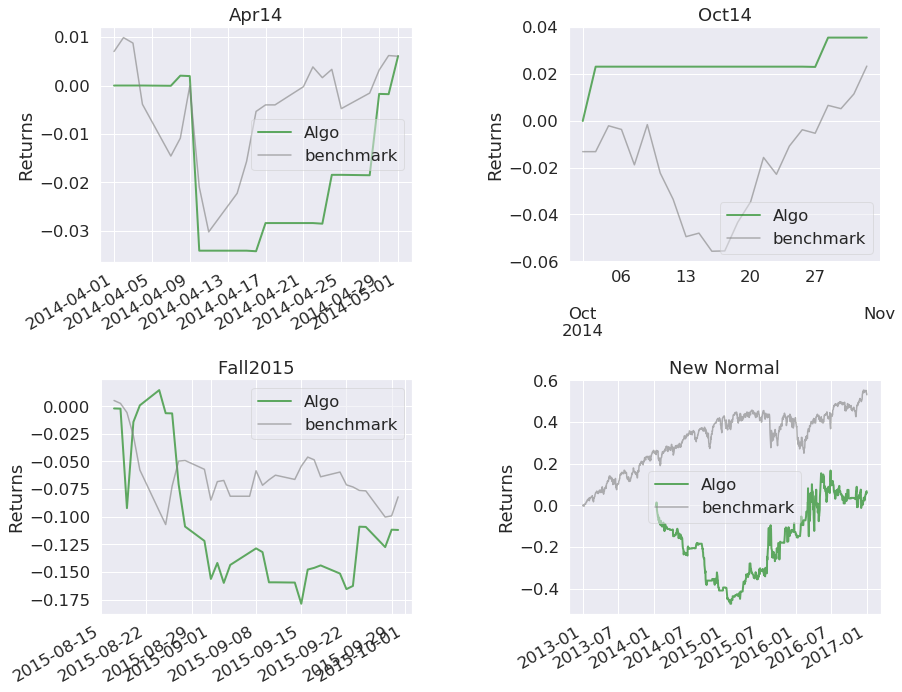

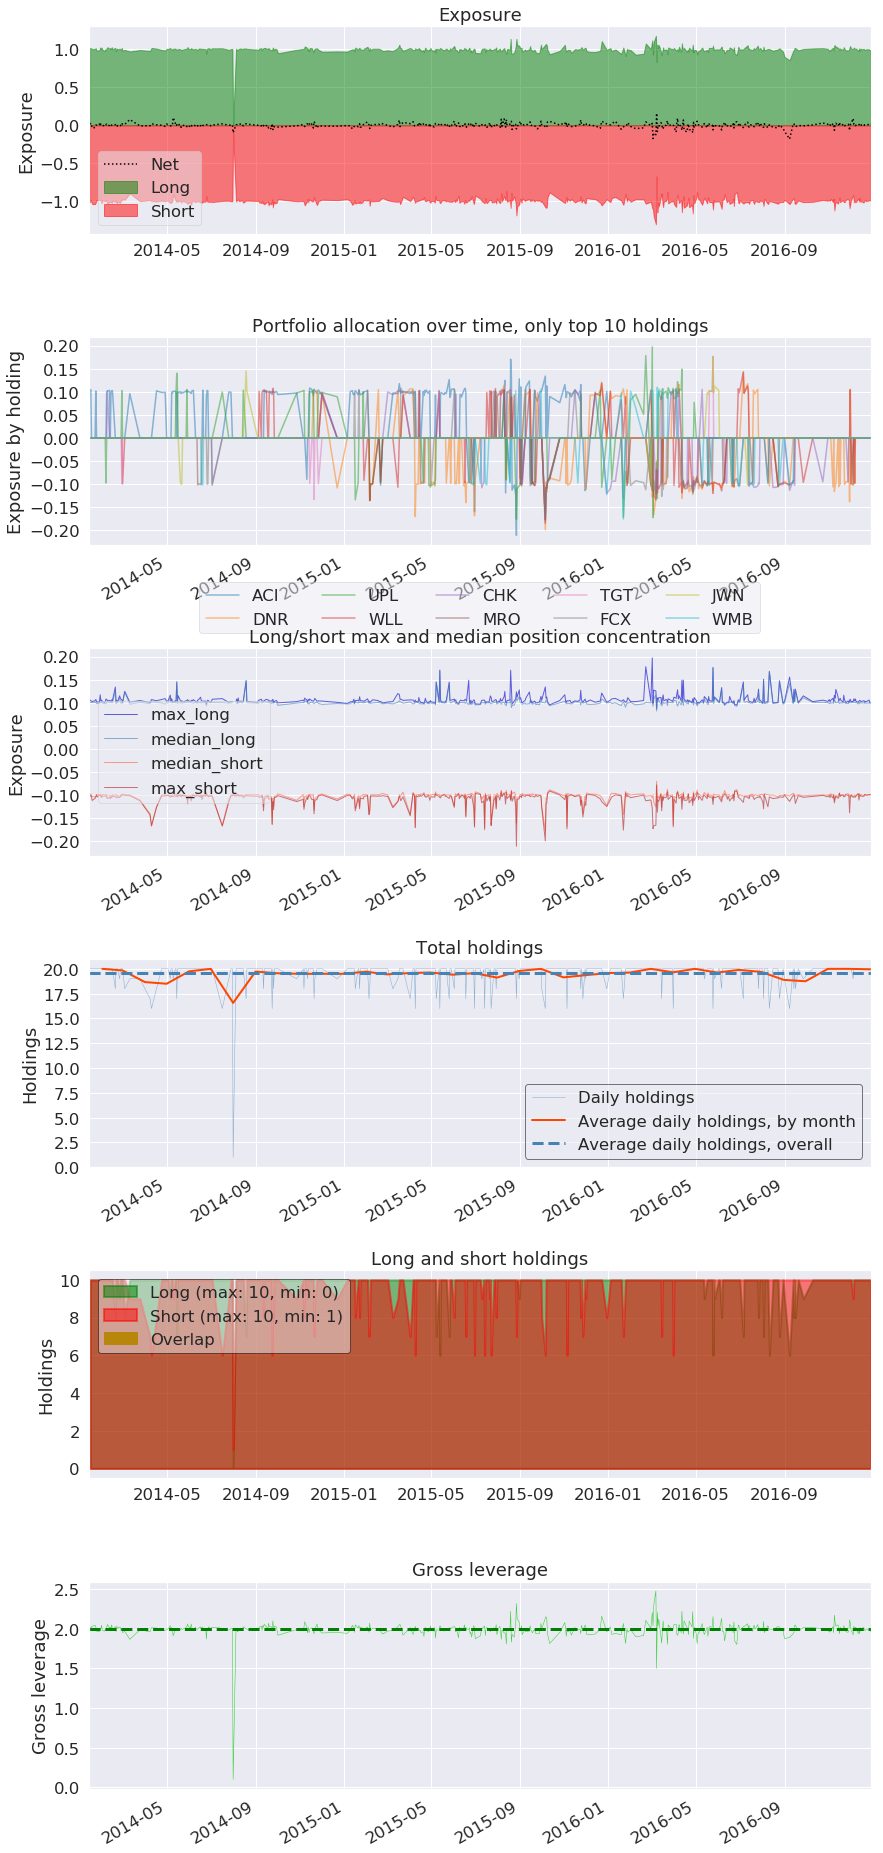

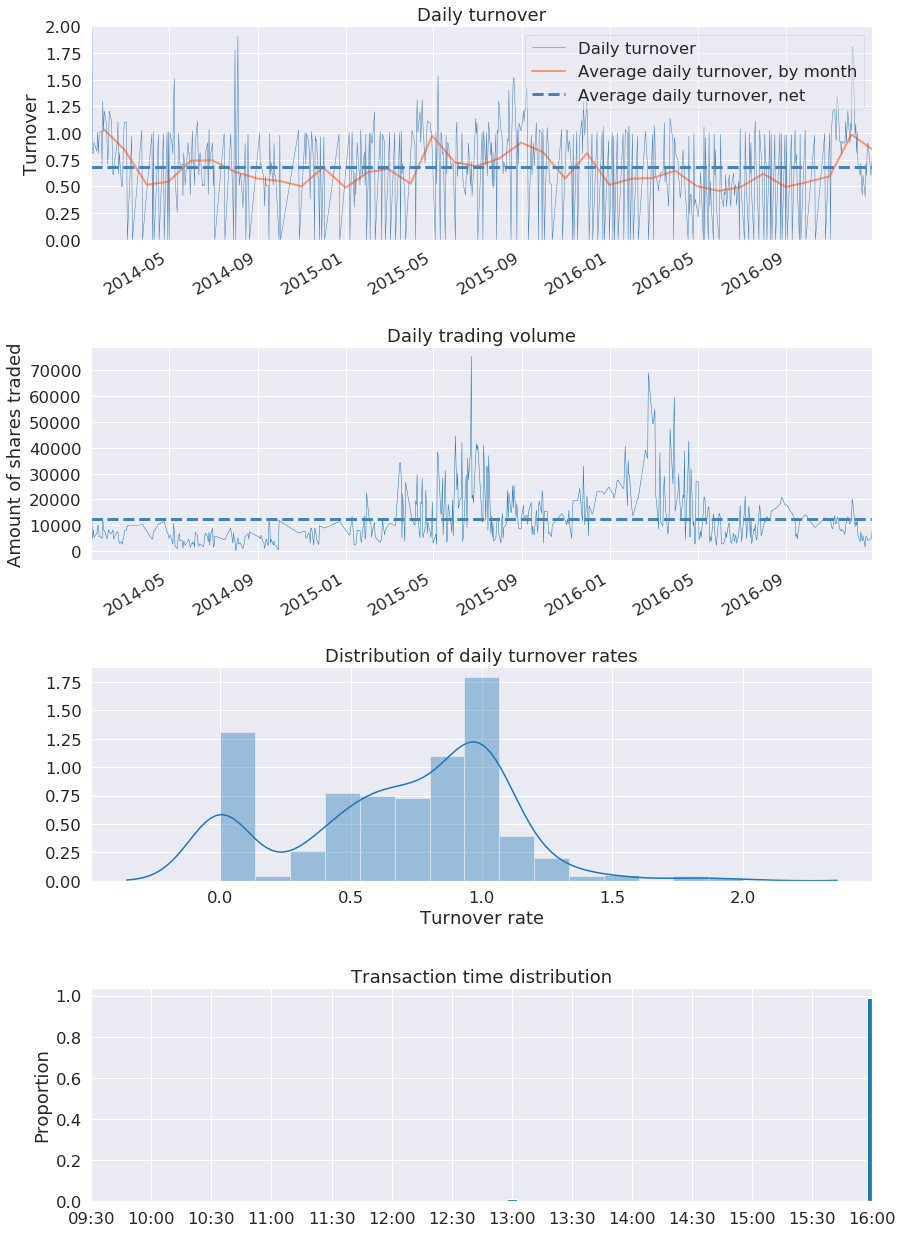

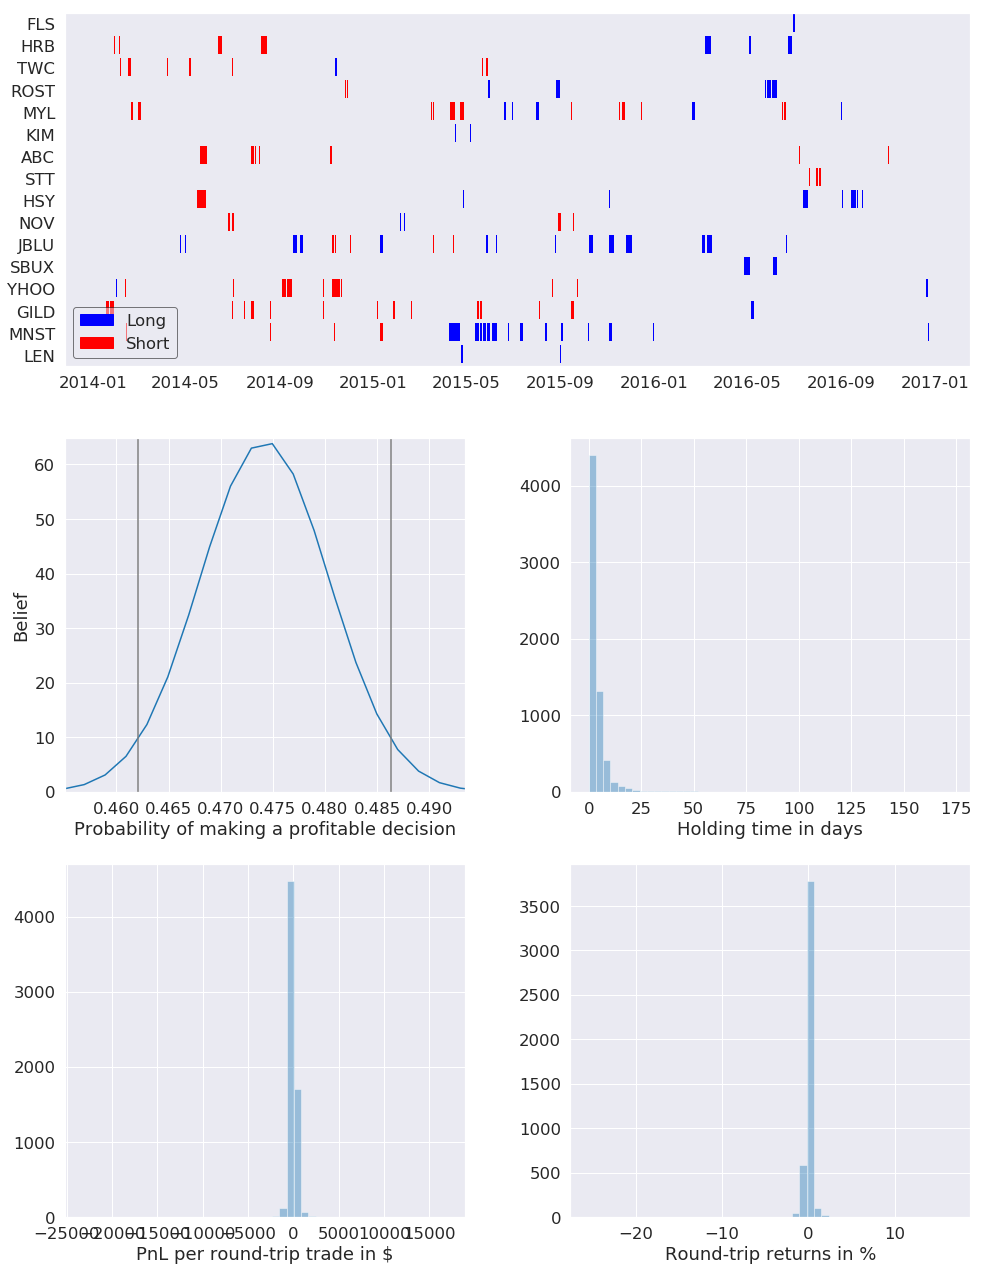

In [54]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          round_trips=True)